## Objective

My goal with this notebook is to focus on model building, rather than data wrangling. For that reason I will work with one of the toy datasets bundled with sklearn.

The dataset is the breast cancer dataset, and so the problem is one of classification.

In [59]:
import pandas as pd
import sklearn
from collections import defaultdict
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":150})

breast_cancer = sklearn.datasets.load_breast_cancer(as_frame=True)

dat = breast_cancer.data
dat['target'] = breast_cancer.target
dat.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Quick review of the data

In [3]:
len(breast_cancer.feature_names)

30

The dataset contains 30 features.

<AxesSubplot:>

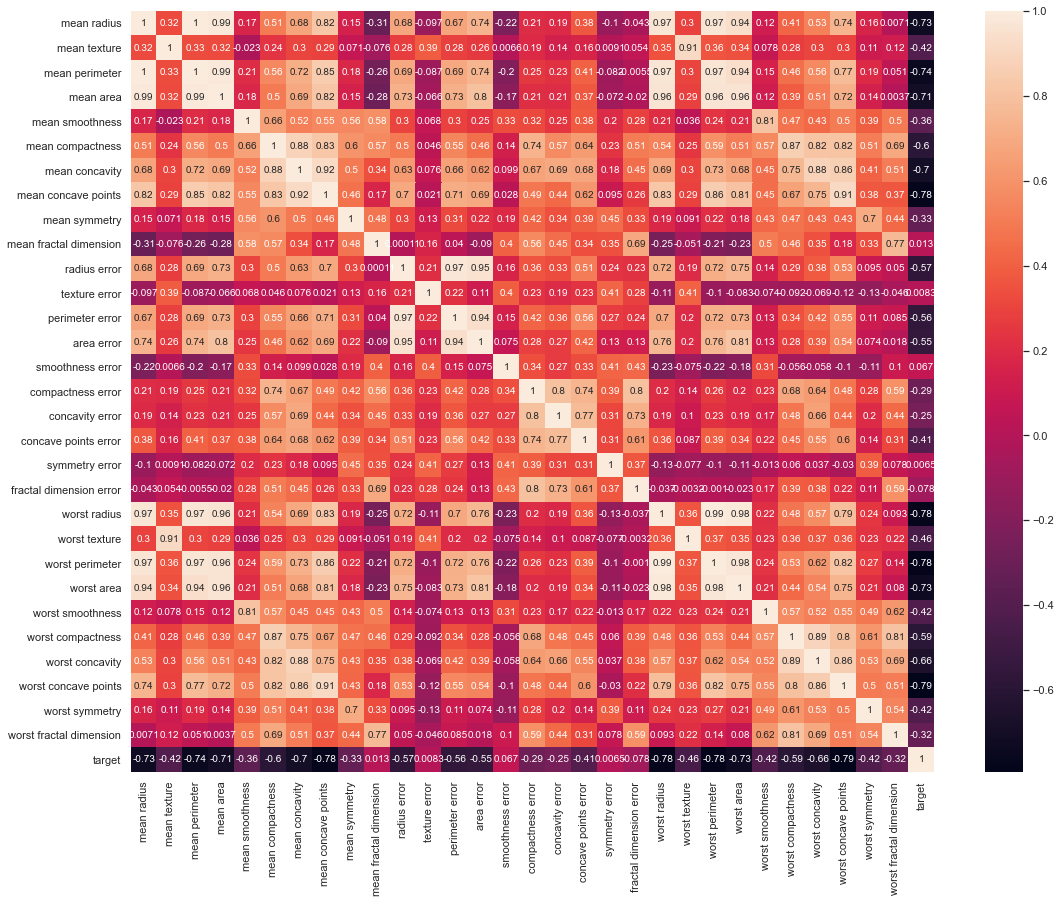

In [4]:
f, ax = plt.subplots(figsize=(18,14))
corr = dat.corr()
sns.heatmap(corr, annot=True)

Some of the variables are highly correlated. This may affect inference and is something to be aware of.

In [5]:
dat.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

There are no missing values.

In [6]:
dat['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

The targets are not quite 50% each, but the imbalance is fairly small. This is good because otherwise a model could perform well by simply guessing the majority class every time.

## Try a bunch of models

In [9]:
# Prepare train/test data
y = dat['target']
X = dat.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)


# Set up multiple models
names = [
    'LogisticRegression',
    'SGD',
    'SVC',
    'KNeighbors',
    'AdaBoost',
    'RandomForest'
]

models = [
    LogisticRegression(),
    SGDClassifier(),
    SVC(),
    KNeighborsClassifier(),
    AdaBoostClassifier(),
    RandomForestClassifier()
]

# Run the models and test the results
d = defaultdict(list)
for name, model in zip(names, models):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    d['Model'].append(name)
    d['Score'].append(score)
d = pd.DataFrame(d)
d

/Users/mdunford/opt/anaconda3/envs/mydashenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Model,Score
0,LogisticRegression,0.946809
1,SGD,0.898936
2,SVC,0.888298
3,KNeighbors,0.898936
4,AdaBoost,0.936170
5,RandomForest,0.925532


Logistic regression initially performs the best. However, this is without any cross validation or hyperparameter tuning. Let's try cross validation first.

## Try a bunch of models with cross validation

/Users/mdunford/opt/anaconda3/envs/mydashenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mdunford/opt/anaconda3/envs/mydashenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

<AxesSubplot:xlabel='Score', ylabel='Model'>

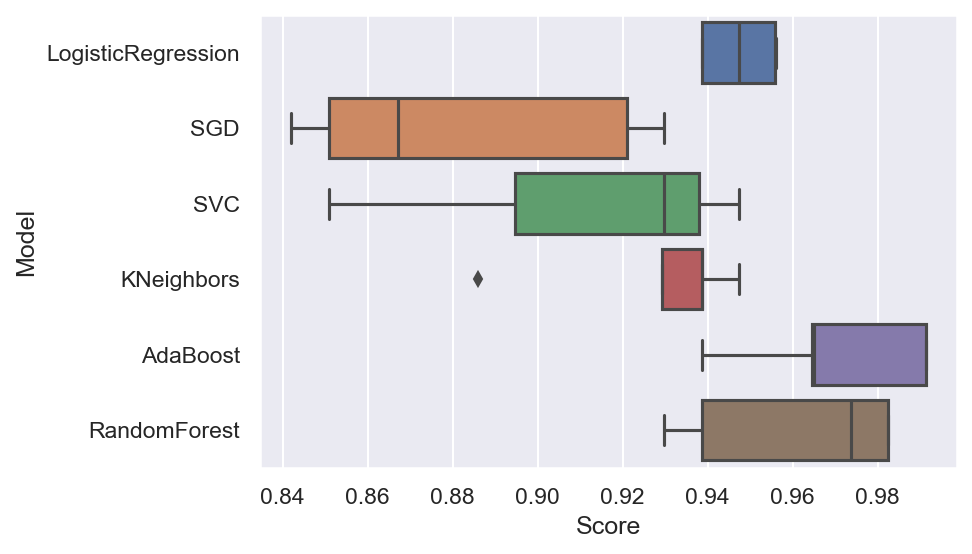

In [56]:
# Set up multiple models
names = [
    'LogisticRegression',
    'SGD',
    'SVC',
    'KNeighbors',
    'AdaBoost',
    'RandomForest'
]

models = [
    LogisticRegression(),
    SGDClassifier(),
    SVC(),
    KNeighborsClassifier(),
    AdaBoostClassifier(),
    RandomForestClassifier()
]

# Run the models and test the results
d = defaultdict(list)
for name, model in zip(names, models):
    cv_scores = cross_val_score(model, X, y, cv=5)
    for score in cv_scores:
        d['Model'].append(name)
        d['Score'].append(score)
d = pd.DataFrame(d)


sns.boxplot(data=d, y='Model', x='Score')

RandomForest and AdaBoost perform the best. Both of these are ensemble methods.

I will now carry out some hyperparameter tuning on these two models using a grid search.

## Tune hyperparameters with grid search

### AdaBoost

In [19]:
n_estimators = np.arange(10,210,10)
learning_rate = np.arange(0.1,2.1,0.1)

param_grid = {
    'n_estimators':n_estimators,
    'learning_rate':learning_rate
}

model = AdaBoostClassifier()
grid = GridSearchCV(model, param_grid)
grid.fit(X, y)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])})

In [22]:
grid.best_estimator_

AdaBoostClassifier(learning_rate=1.2000000000000002, n_estimators=190)

In [21]:
model = AdaBoostClassifier(learning_rate=0.6, n_estimators=170)
cv_scores = cross_val_score(model, X, y, cv=3)
cv_scores.mean()

0.9718834122342894

It is worth noting that AdaBoost uses a base model which it builds upon. In the default case (which I am using) this is a decision tree, so both the models which are performing best are tree based.

### RandomForest

There are many hyperparameters for the random forest model.

In [10]:
# RandomForest
n_estimators = np.arange(50,260,10)
max_features = ['auto','sqrt','log2']

param_grid = {
    'n_estimators':n_estimators,
    'max_features':max_features
}

model = RandomForestClassifier()
forest_grid = GridSearchCV(model, param_grid)
forest_grid.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250])})

In [16]:
forest_grid.best_estimator_

RandomForestClassifier(max_features='log2', n_estimators=70)

In [17]:
model = RandomForestClassifier(n_estimators=70, max_features='log2')
cv_scores = cross_val_score(model, X, y, cv=3)
cv_scores.mean()

0.9578390420495685

## Further review

It seems that AdaBoost is the best performing model that I have tried. After settling on a model I will explore the way it is performing in a bit more detail in order to understand it better

I can use the grid object resulting from the grid search to understand how the hyperparameters affect the accuracy.

In [43]:
params = grid.cv_results_['params']
scores = grid.cv_results_['mean_test_score']
params = pd.DataFrame(params)
params['score'] = scores
params.head()

,learning_rate,n_estimators,score
0,0.1,10,0.936780
1,0.1,20,0.945552
2,0.1,30,0.947306
3,0.1,40,0.950831
4,0.1,50,0.956078


<AxesSubplot:xlabel='n_estimators', ylabel='learning_rate'>

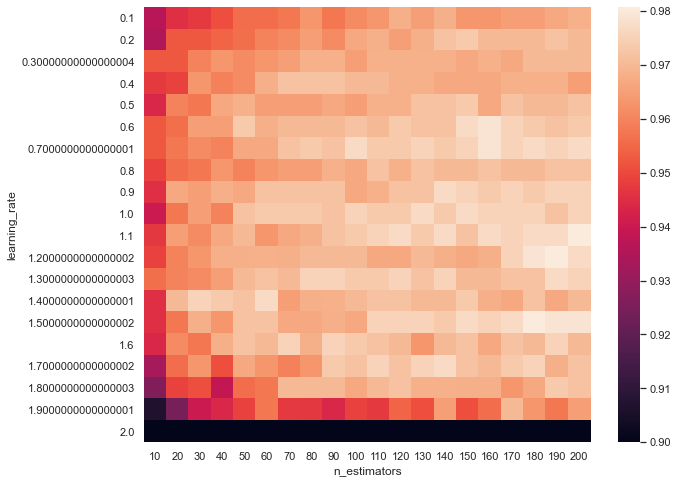

In [51]:
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data=pd.pivot_table(params, index='learning_rate', columns='n_estimators', values='score'), vmin=0.9)

Now, using the parameters discovered via the grid search, take a look at the accuracy in more detail.

In [57]:
# Prepare train/test data
y = dat['target']
X = dat.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

clf = AdaBoostClassifier(learning_rate=0.6, n_estimators=170)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        65
           1       0.97      0.99      0.98       123

    accuracy                           0.97       188
   macro avg       0.98      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188



Let's look at a ROC curve.

In [73]:
r_probs = [0 for i in range(len(y_test))]
clf_probs = clf.predict_proba(X_test)
clf_probs = clf_probs[:,1]

fpr, tpr, _ = roc_curve(y_test, clf_probs)
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)

Text(0, 0.5, 'TPR')

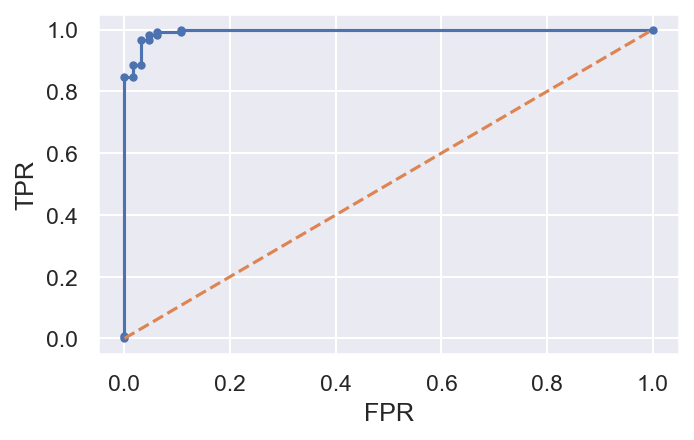

In [76]:
f, ax = plt.subplots(figsize=(5,3))
plt.plot(fpr, tpr, marker='.')
plt.plot(r_fpr, r_tpr, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')

This is a good curve as the closer to the top left, the better. It means that we can increase the true positive rate a long way before we see any increases in tjhe false positive rate.